# Image Classification Using EfficientNet

This Code Template is for simple image classification using EfficientNet.

<img src="https://cdn.blobcity.com/assets/gpu_required.png"  height="25" style="margin-bottom:-15px" />

In [57]:
!pip install pytorch
!pip install efficientnet_pytorch

In [2]:
import os
import numpy as np
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from PIL import Image
from tqdm.notebook import tqdm
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# PyTorch Modules
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from efficientnet_pytorch import EfficientNet

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Initialization
Path of the main folder containing train and test folders

In [6]:
BASE_DIR = ''
print(os.listdir(BASE_DIR))

['val', 'train']


Path of the train and test folders containing image files

In [7]:
train_dir = os.path.join(BASE_DIR, 'train') #train
test_dir = os.path.join(BASE_DIR, 'test') #test

List of target categories which are required for model training and predictions.

In [8]:
target = []

In [9]:
print(len(target))

3


### Directory Structure
The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Master Directory</b>
 |__<b>train</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
 |__<b>test</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
</pre>

In [10]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

### Data Preprocessing (normalization & data augmentation)

Transforms are common image transformations. They can be chained together using Compose. Most transform classes have a function equivalent: functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline.

1. **Resize**:
>Resize the input image to the given size. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions
- Class
          torchvision.transforms.Resize(size, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, max_size=None, antialias=None)

2. **RandomCrop**:
> Crop the given image at a random location. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions, but if non-constant padding is used, the input is expected to have at most 2 leading dimensions
- Class
          torchvision.transforms.RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')

3. **RandomHorizontalFlip**:	
>Horizontally flip the given image randomly with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions
- Class 
          torchvision.transforms.RandomHorizontalFlip(p=0.5)

4. **RandomRotation**: 
> Rotate the image by angle. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.
- Class
      torchvision.transforms.RandomRotation(degrees, interpolation=<InterpolationMode.NEAREST: 'nearest'>, expand=False, center=None, fill=0, resample=None)

5. **ColorJitter**:	 
>Randomly change the brightness, contrast, saturation and hue of an image. If the image is torch Tensor, it is expected to have […, 3, H, W] shape, where … means an arbitrary number of leading dimensions. If img is PIL Image, mode “1”, “L”, “I”, “F” and modes with transparency (alpha channel) are not supported.
- Class
      torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)


6. **ToTensor**:
>Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
- Class 
      torchvision.transforms.ToTensor

7. **RandomPerspective**: 
>Performs a random perspective transformation of the given image with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.
- Class
      torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, fill=0)

8. **Normalize**:
>Normalize a tensor image with mean and standard deviation. This transform does not support PIL Image. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]
- Class
      torchvision.transforms.Normalize(mean, std, inplace=False)


For more information, refer to this [API](https://pytorch.org/vision/stable/transforms.html)

In [11]:
imagenet_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # mean and std of imagenet

train_tfms = T.Compose([ 
                            T.Resize(225),
                            T.RandomCrop(224),
                            T.RandomHorizontalFlip(), 
                            T.RandomRotation(degrees=(-45, 45)),
                            T.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
                            T.ToTensor(),
                            T.RandomPerspective(distortion_scale=0.2, p=0.5),
                            T.Normalize(*imagenet_stats, inplace=True)])

val_tfms = T.Compose([
                        T.Resize(225),
                        T.CenterCrop(224), 
                        T.ToTensor(),
                        T.Normalize(*imagenet_stats)])

### Creating Pytorch Datasets Using ImageFolder and Dataloader 

In [12]:
# PyTorch datasets
train_ds = ImageFolder(train_dir, train_tfms)
valid_ds = ImageFolder(test_dir, val_tfms)

In [13]:
print(len(train_ds))
print(len(valid_ds))

14630
1500


### Creating Training and Validation Sets

In [16]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

### Display a Grid of Augmented Data

In [17]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


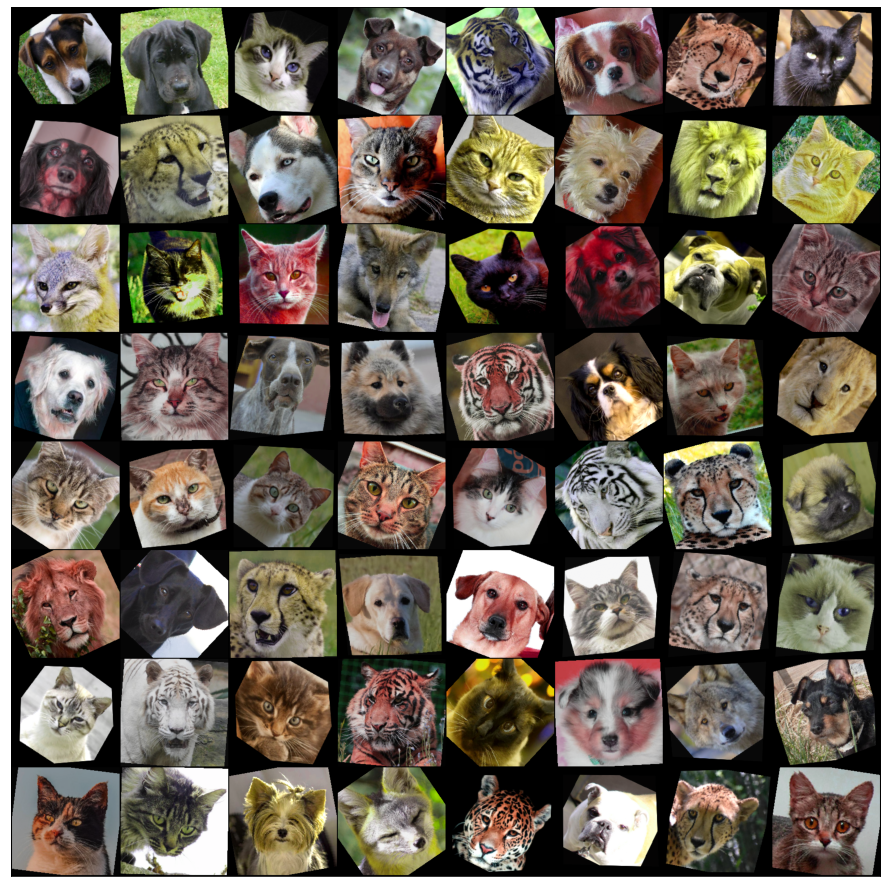

In [19]:
show_batch(train_dl)

### Modifying a Pretrained Model (ResNet101)

Transfer learning :

![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


In [20]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


### Model

EfficientNet, first introduced in Tan and Le, 2019 is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

The smallest base model is similar to MnasNet, which reached near-SOTA with a significantly smaller model. By introducing a heuristic way to scale the model, EfficientNet provides a family of models (B0 to B7) that represents a good combination of efficiency and accuracy on a variety of scales. Such a scaling heuristics (compound-scaling, details see Tan and Le, 2019) allows the efficiency-oriented base model (B0) to surpass models at every scale, while avoiding extensive grid-search of hyperparameters.


### Parameters of EfficientNet
    
Arguments

* **include_top**: Whether to include the fully-connected layer at the top of the network. Defaults to True.
* **weights**: One of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded. Defaults to 'imagenet'.
* **input_tensor**: Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
* **input_shape**: Optional shape tuple, only to be specified if include_top is False. It should have exactly 3 inputs channels.
* **pooling**: Optional pooling mode for feature extraction when include_top is False. Defaults to None. - None means that the output of the model will be the 4D tensor output of the last convolutional layer. - avg means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor. - max means that global max pooling will be applied.
* **classes**: Optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified. Defaults to 1000 (number of ImageNet classes).
* **classifier_activation**: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. Defaults to 'softmax'. When loading pretrained weights, classifier_activation can only be None or "softmax".

In [22]:
class EffiModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = EfficientNet.from_pretrained('efficientnet-b0')
        # Replace last layer
        self.network.fc = nn.Linear(self.network._fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## GPU Utilities and Training Loop

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [24]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [27]:
model = EffiModel(len(target))
to_device(model, device);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [28]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [29]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.0, 'val_loss': 9.337306022644043}]

In [30]:
# Hyperparameters
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

# Training Cycle with Learning Rate Scheduler

In [31]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00759, train_loss: 0.3309, val_loss: 5.1644, val_acc: 0.5609


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00950, train_loss: 0.1406, val_loss: 0.6319, val_acc: 0.7272


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00611, train_loss: 0.0760, val_loss: 1.1698, val_acc: 0.6190


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00188, train_loss: 0.0426, val_loss: 0.7110, val_acc: 0.6107


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00000, train_loss: 0.0163, val_loss: 0.0194, val_acc: 0.9958
CPU times: user 5min 29s, sys: 3min 27s, total: 8min 56s
Wall time: 20min 45s


In [43]:
torch.save(model.state_dict(), 'filename.pth')

# Plots

In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [34]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

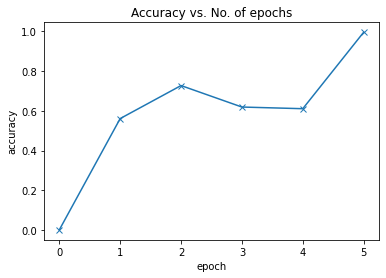

In [35]:
plot_accuracies(history)

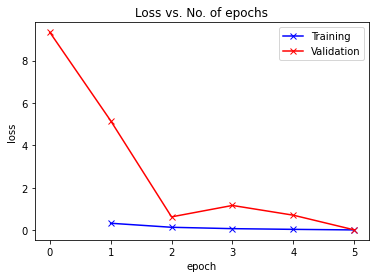

In [36]:
plot_losses(history)

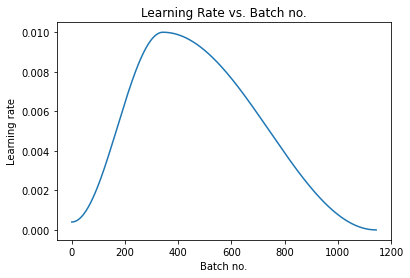

In [37]:
plot_lrs(history)

### Model Evaluation (Accuracy)

In [39]:
result = evaluate(model, valid_dl)
print('Loss : ', result['val_loss'])
print('Accuracy : ', result['val_acc'])

Loss :  0.019410934299230576
Accuracy :  0.9958389401435852


### Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

In [50]:
def get_confusion_matrix(data, N):
  print("Generating confusion matrix", N)
  with torch.no_grad():
    predictions = []
    targets = []
    i = 0
    for x, y in data:
      i += 1
      if i % 50 == 0:
        print(i)

      # transfer image to gpu if available
      # x = to_device(x, device)
      # Get predictions from model
      p = model(x)
      # Pick index with highest probability
      _, y_pred  = torch.max(p, dim=1)

      predictions = np.concatenate((predictions, y_pred))
      targets = np.concatenate((targets, y))

      if len(targets) >= N:
        break
    cm = confusion_matrix(targets, predictions)
    
  return predictions,targets,cm

In [52]:
y_pred, y_target, cm = get_confusion_matrix(valid_dl, len(test_image_files))

Generating confusion matrix 1500


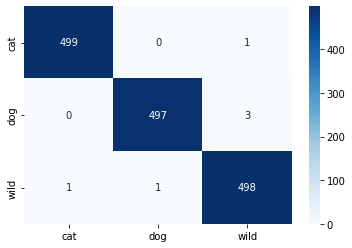

In [53]:
sns.heatmap(cm,
            annot = True,
            fmt = 'd',
            xticklabels=target, 
            yticklabels= target,
            cmap = plt.cm.Blues)
plt.show()

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [54]:
print(classification_report(y_target, y_pred, target_names=target))

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.99      1.00       500
        wild       0.99      1.00      0.99       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



#### Creator: Ganapathi Thota , Github: [Profile](https://github.com/Shikiz)